# Diabetes Predictor Model - Modeling

### In this notebook we will:
### 1. Apply 2-3 different modeling methods
### 2. Apply model hyperparameter tuning methods
### 3. Define the metrics I use to choose my final model
### 4. Evaluate the performance of the different models 
### 5. Identify one of the models as the best model 

##### The main objective is to develop a binary classification model to predict if an individual has Diabetes using their personal and health indicators

### Imports

In [4]:
!pip install xgboost

In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.api import abline_plot

from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, roc_auc_score, \
confusion_matrix, classification_report, precision_score, recall_score, f1_score, precision_recall_curve, \
make_scorer, recall_score, ConfusionMatrixDisplay, roc_curve, precision_recall_curve

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

import xgboost as xgb
from xgboost import XGBClassifier, DMatrix

#show plots inline
%matplotlib inline

##### Since I have a binary classification problem, I am going to use the following modeling methods...
##### 1. XGBoost (tree-based model)
##### 2. K-Nearest Neighbors (KNN) (instance-based model)
##### 3. Support Vector Machine (SVM) (margin-based model)

### Loading the Data

In [5]:
# Reading the saved CSV's
# Using .squeeze() to turn my single-column DataFrame into a Series

X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv').squeeze()
y_test = pd.read_csv('y_test.csv').squeeze()

In [7]:
# Ensuring the shapes match

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(202944, 21) (202944,)
(50736, 21) (50736,)


In [9]:
print(X_train.dtypes)

HighBP                  int64
HighChol                int64
CholCheck               int64
BMI                     int64
Smoker                  int64
Stroke                  int64
HeartDiseaseorAttack    int64
PhysActivity            int64
Fruits                  int64
Veggies                 int64
HvyAlcoholConsump       int64
AnyHealthcare           int64
NoDocbcCost             int64
GenHlth                 int64
MentHlth                int64
PhysHlth                int64
DiffWalk                int64
Sex                     int64
Age                     int64
Education               int64
Income                  int64
dtype: object


In [11]:
print(y_train.dtypes)

int64


### XGBoost Model

In [14]:
# Creating a SMOTE + XGB pipeline
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('xgb', XGBClassifier(
        objective='binary:logistic',
        booster='gbtree',
        eval_metric='logloss',
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    ))
])

In [16]:
# Applying hyperparameter tuning
param_grid = {
    'xgb__n_estimators': [100, 200, 400],
    'xgb__learning_rate': [0.01, 0.03, 0.1],
    'xgb__max_depth': [3, 5, 7],
    'xgb__subsample': [0.6, 0.8, 1.0],
    'xgb__colsample_bytree': [0.6, 0.8, 1.0],
    'xgb__gamma': [0, 1, 5],
    'xgb__min_child_weight': [1, 3, 5],
    'xgb__reg_alpha': [0, 0.1, 1],
    'xgb__reg_lambda': [1, 5, 10]
}

In [18]:
# Using RandomizedSearchCV to determine the best hyperparameters for the XGB model

rand = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=10,
    scoring='recall',
    cv=3,
    random_state=42,
    n_jobs=1,
    verbose=2
)


rand.fit(X_train, y_train)
best_xgb = rand.best_estimator_

print("Best Score:" + str(rand.best_score_))
print("Best Parameters: " + str(rand.best_params_))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END xgb__colsample_bytree=1.0, xgb__gamma=1, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__reg_alpha=0, xgb__reg_lambda=1, xgb__subsample=0.6; total time=   5.9s
[CV] END xgb__colsample_bytree=1.0, xgb__gamma=1, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__reg_alpha=0, xgb__reg_lambda=1, xgb__subsample=0.6; total time=   6.4s
[CV] END xgb__colsample_bytree=1.0, xgb__gamma=1, xgb__learning_rate=0.01, xgb__max_depth=7, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__reg_alpha=0, xgb__reg_lambda=1, xgb__subsample=0.6; total time=   6.6s
[CV] END xgb__colsample_bytree=0.6, xgb__gamma=0, xgb__learning_rate=0.03, xgb__max_depth=3, xgb__min_child_weight=3, xgb__n_estimators=200, xgb__reg_alpha=1, xgb__reg_lambda=5, xgb__subsample=1.0; total time=   5.9s
[CV] END xgb__colsample_bytree=0.6, xgb__gamma=0, xgb__learning_rate=0.

In [20]:
# Getting predictions
y_pred = best_xgb.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.68      0.79     42741
           1       0.32      0.78      0.45      7995

    accuracy                           0.70     50736
   macro avg       0.63      0.73      0.62     50736
weighted avg       0.84      0.70      0.74     50736



##### My model is maximizing on recall as not catching a diabetes diagnosis can be severe
##### Recall is good but I sacrificed precision

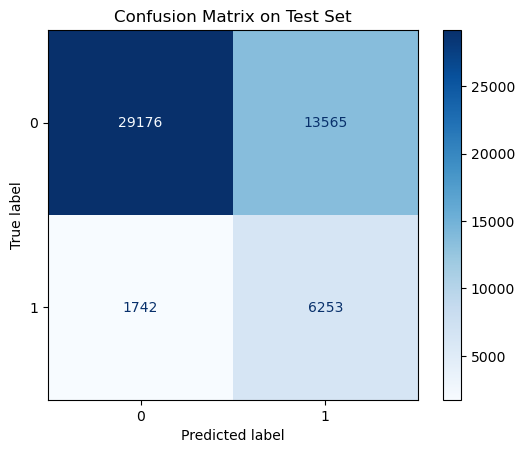

In [22]:
# Making a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting
ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.title('Confusion Matrix on Test Set')
plt.show()

##### Based on the confusion matrix...
##### 1.) There are 29176 correct diabetes predictions
##### 2.) There are 6253 correct predictions for non-diabetes
##### 3.) There are 13565 diabetes predictions that are wrong
##### 4.) There are 1742 non-diabetes predictions that are wrong

AUC Score: 0.8068511737268703.2f


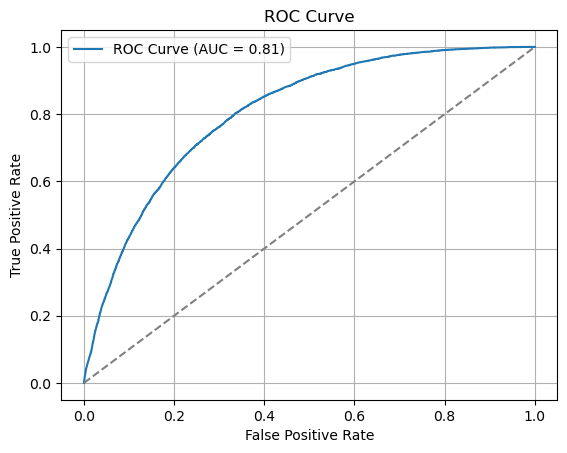

In [32]:
# Calculating the ROC for the XGBoost model

#Predicting probabilities
y_probs = best_xgb.predict_proba(X_test)[:, 1]

# Calculating ROC curve
# fpr = false positive rate
# tpr = true positive rate
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Calculating AUC score
auc_score = roc_auc_score(y_test, y_probs)
print(f'AUC Score: {auc_score}.2f')

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

##### An AUC score of 1 is a perfect model
##### An AUC score of 0.5 is no better than random

#### My AUC score is 0.81, indicating a good ability to distinguish the two classes (diabetic and non-diabetic)

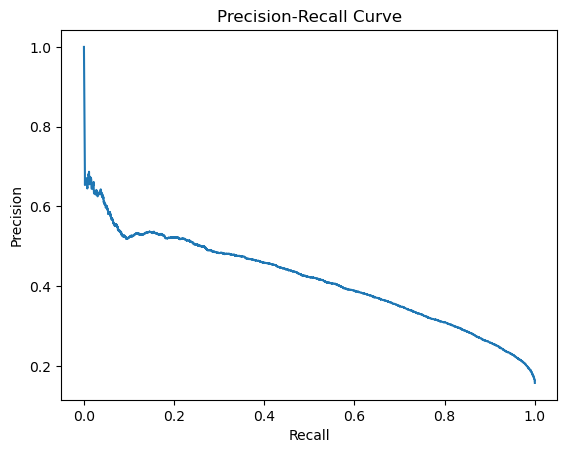

In [38]:
# Plotting my precision-recall curve
prec, rec, _ = precision_recall_curve(y_test, y_probs)
plt.figure()
plt.plot(rec, prec)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

##### The x-axis is...of all true diabetics, what fraction you predicted as positive
##### The y-axis is...of all cases the model predicted positive, what fraction are actually diabetic

## K-Nearest Neighbors (KNN)

##### KNN is distance-based, so I must scale my features

In [48]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [79]:
param_grid = {
    'n_neighbors': list(range(1, 11)),
    'weights': ['uniform', 'distance'],
}

In [81]:
# Instantiating RandomizedSearchCV
rand = RandomizedSearchCV(
    estimator=KNeighborsClassifier(algorithm='auto', n_jobs=2),
    param_distributions=param_grid,
    n_iter=20,
    scoring='recall',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fitting to training data
rand.fit(X_train_scaled, y_train)

# Examining best results
print(f'Best K: {rand.best_params_["n_neighbors"]}')
print(f'Best recall: {rand.best_score_}')

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best K: 1
Best recall: 0.31817890003595367


##### My randomized search is telling me that k=1 is going to give me the best recall
##### This is not ideal as my model is literally "memorizing" each training point and is overfitting, it will not generalize well to new data

In [84]:
# Getting best KNN model
best_knn = rand.best_estimator_

In [86]:
# Getting predictions
y_pred = best_knn.predict(X_test_scaled)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87     42741
           1       0.32      0.32      0.32      7995

    accuracy                           0.79     50736
   macro avg       0.60      0.60      0.60     50736
weighted avg       0.79      0.79      0.79     50736



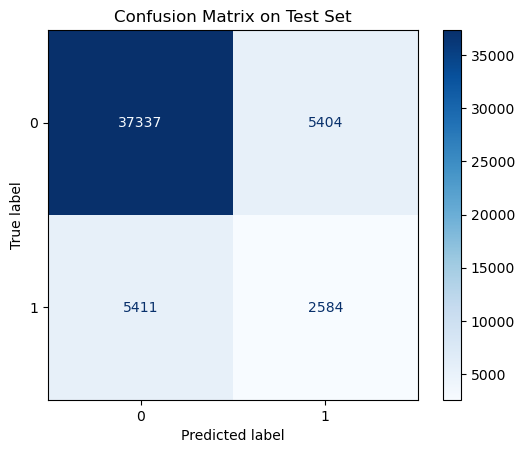

In [88]:
# Making a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting
ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.title('Confusion Matrix on Test Set')
plt.show()

##### Based on the confusion matrix...
##### 1.) There are 37337 correct diabetes predictions
##### 2.) There are 2584 correct predictions for non-diabetes
##### 3.) There are 5404 diabetes predictions that are wrong
##### 4.) There are 5411 non-diabetes predictions that are wrong

## SVM

In [112]:
# Resampling only on training data because of class imbalance
X_res, y_res = SMOTE(random_state=42).fit_resample(X_train, y_train)

In [114]:
# Building a pipeline to scale and balance
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(probability=True))
])

In [116]:
# Defining my hyperparameter search space
param_grid = {
    'svc__C': np.logspace(-2, 1, 4),
    'svc__gamma': np.logspace(-3, 0, 4)
}

In [118]:
# Setting up RandomizedSearchCV
rand = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=8,
    scoring='recall',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fitting
rand.fit(X_res, y_res)

print("Best params:", rand.best_params_)
print("Best CV recall:", rand.best_score_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


KeyboardInterrupt: 